In [15]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:blue'>(1) Preprocessing: Detect face and eyes</h3>

(549, 976, 3)


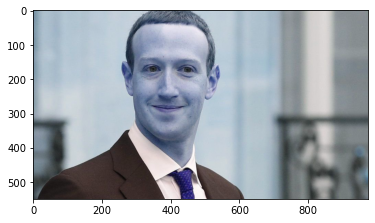

In [16]:
img = cv2.imread('./test_images/mark1.jpg')  
print(img.shape)
plt.imshow(img)

(549, 976)


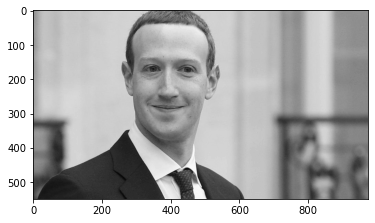

In [17]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')  

here we will use haar cascade method to detect face and eyes

we have used here haar cascade function from open cv

In [18]:
cascaded_face = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
cascaded_eye = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = cascaded_face.detectMultiScale(gray, 1.3, 5)
faces  

array([[249,  61, 293, 293]], dtype=int32)

In [19]:
(x, y, w, h) = faces[0] # find out the coodrdinates

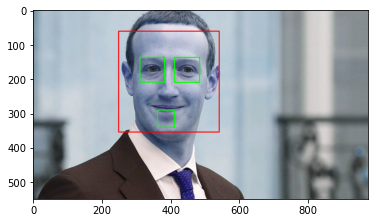

In [20]:
#rectangle has build from (x,y) to (x+w, y+h) with the help of coordinates

cv2.destroyAllWindows()

#for getting the face area(roi means region interest)
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) 
    #here 255 is placed in 1st place to give the red colour rectange(think like rgb)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    
    # for getting the eye area
    eyes = cascaded_eye.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)  
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()   

<h3 style='color:blue'>(2) Preprocessing: Crop the facial region of the image</h3>

(293, 293, 3)


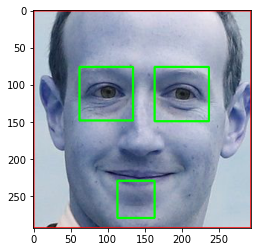

In [21]:
#Now Crop the facial region of the image
cropped_img = np.array(roi_color)
print(cropped_img.shape)
plt.imshow(roi_color, cmap='gray')

Now we will build the function for cropped the images(for all the images we will use in this project) according to the haar cascade


if eyes >=2, then save and crop the face region


In [22]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = cascaded_face.detectMultiScale(gray, 1.3, 5)
    
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = cascaded_eye.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color      

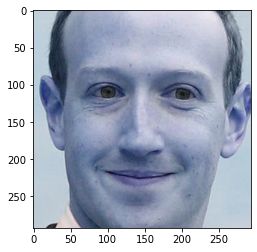

In [23]:
original_image = cv2.imread('./test_images/mark1.jpg')
cropped_image = get_cropped_image_if_2_eyes('./test_images/mark1.jpg')
plt.imshow(cropped_image)

now we will set a fault image example such that it can be ignore during processing

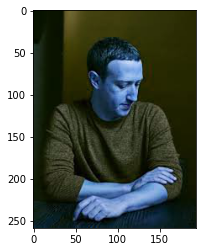

In [24]:
org_image_obstructed = cv2.imread('./test_images/mark2.jpg') 
plt.imshow(org_image_obstructed) 

in above picture as shown eyes are not proper visible so we will ignore these type of images for model training

In [25]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/mark2.jpg')

<h3 style='color:blue'>(3) Data Cleaning</h3>

In [26]:
path_to_data = "./dataset/"         
path_to_cr_data = "./dataset/cropped/"

In [27]:
# now will go through the path and check how many folders are present in the dataset and append to img_dirs
import os
img_dirs = []

for entry in os.scandir(path_to_data):  
    if entry.is_dir():
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/elon_musk',
 './dataset/jeff_bezos',
 './dataset/larry_page',
 './dataset/mark_zuckerberg']

Now we will create the desired folder on the given path or if there is present any folder related to desired then it will delete it and make the new one

In [28]:
import shutil

if os.path.exists(path_to_cr_data):  # if any cropped folder exist then remove it
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)            # make a new cropped folder



cropped_image_dirs = []
person_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    person_name = img_dir.split('/')[-1]   
    
    
    person_file_names_dict[person_name] = []   
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)  
        
        if roi_color is not None:
            cropped_folder = path_to_cr_data + person_name
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = person_name + str(count) + ".png"   
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            person_file_names_dict[person_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/elon_musk
Generating cropped images in folder:  ./dataset/cropped/jeff_bezos
Generating cropped images in folder:  ./dataset/cropped/larry_page
Generating cropped images in folder:  ./dataset/cropped/mark_zuckerberg


Now if any manual clean is needed then do it means if any thing unwanted is still present in cropped images

In [29]:
person_file_names_dict = {}
for img_dir in cropped_image_dirs:
    person_name = img_dir.split('/')[-1]
    
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    person_file_names_dict[person_name] = file_list

In [30]:
class_dict = {}     
count = 0

for person_name in person_file_names_dict.keys():
    class_dict[person_name] = count
    count = count + 1
    
class_dict

{'elon_musk': 0, 'jeff_bezos': 1, 'larry_page': 2, 'mark_zuckerberg': 3}

<h3 style='color:blue'>(4) wavelet transform as a feature for traning our model</h3>

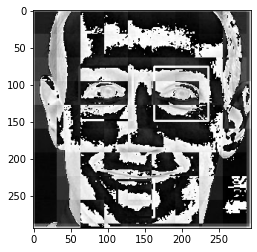

In [31]:
#Now use wavelet transform as a feature for traning our model such as edges, eyes ,nose etc

#This along with raw pixel image can be used as an input for our classifier

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_img,'db1',5)  
plt.imshow(im_har, cmap='gray')

Now We will use these raw images along with wavelet transformed images to train our classifier

Basically it will stack color image and wavlet image vertically because we want to take the important features from both images for training our model


In [32]:
X, y = [], []

for person_name, training_files in person_file_names_dict.items():
    
    for training_image in training_files:
        
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32)) # resize for making same shape as haar image as we have done below 
        
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1))) #3 in 32*32*3 for rgb
        X.append(combined_img)
        y.append(class_dict[person_name]) 
     

In [33]:
len(X) # shows total cropped images of all three

185

In [34]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape    # array of 4096 data points

(185, 4096)

<h3 style='color:blue'>(5) Model building</h3>

In [35]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [36]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.833333,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,logistic_regression,0.854762,{'logisticregression__C': 1}


so we can see the logistic_regression gives good accuracy compare to svm

so according to the above analysis logistic_regression will be best to use

In [38]:
best_clf = best_estimators['logistic_regression']

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

# confusion_matrix will show the frequency of correct prediction

array([[11,  1,  0,  0],
       [ 1,  7,  0,  0],
       [ 1,  0,  9,  1],
       [ 3,  0,  1, 12]], dtype=int64)

Text(69.0, 0.5, 'Truth')

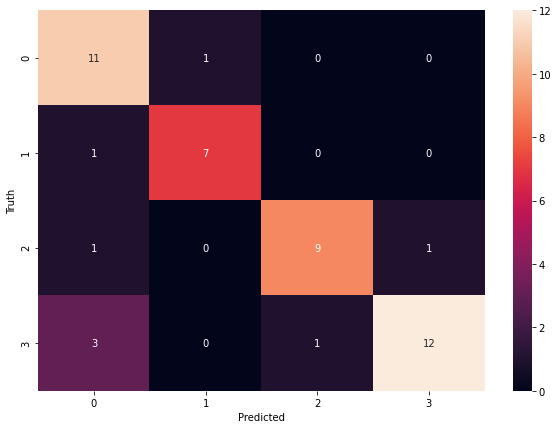

In [40]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_estimators['logistic_regression'], 'saved_model.pkl') 

['saved_model.pkl']

In [42]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))